# 古诗生成器（训练版）

基于循环神经网络（Keras+LSTM-RNN），采用了浙江大学人工智能研究所提供的古诗词库，并且在其提供的AI学习平台上训练完成。本案例非原创，原来的代码用class来实现，并且重构了model的方法。为了方便初学者理解，重新调整了代码，并且用jupyterlab写了一个完整的文档。

虽然模型已经训练完成，但要应用这个模型，还需要提供原来用于训练的语料，即古诗词库。训练和应用使用的语料要保持一致。

运行这个案例，需要安装多个库，还需要pydot、graphviz的支持。虚谷号教育版上已经提供了所有相关的环境。需要说明的是，在虚谷号上训练比较慢，预计至少需要一天时间。

原案例地址：https://github.com/youyuge34/Poems_generator_Keras/blob/master/poem_model.ipynb

模型下载地址（课程汇集/虚谷号内置课程目录/5.机器学习）：https://github.com/vvlink/vvBoard-docs/

## 1.导入必要的库

In [1]:
import random
import os
import keras
import numpy as np
from keras.callbacks import LambdaCallback
from keras.models import Input, Model, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

Using TensorFlow backend.


## 2.参数设置

In [32]:
class config(object):
    # 输入的诗词库（语料库）
    poetry_file = 'data/8-poetry_zju.txt'
    # 模型名称，注意别替换了原来的模型
    weight_file = 'model/8-model_zju.h5'
    # 输出训练的信息
    fixlog = 'poem_log.txt'
    # 复合训练时，间隔多少次输出一次测试结果
    predict_num = 5
    batch_size = 32
    learning_rate = 0.001
    # 下面参数不能随意修改，改动将影响整个模型的大小
    #根据前6个字预测第6个字，生成的是五言诗（加标点）
    max_len = 6
    # 去除低频率文字（避免生僻字）
    frequence_num = 3

## 3.数据处理

In [3]:
def preprocess_file(poetry_file):
    # 语料文本内容
    files_content = ''
    with open(poetry_file, 'r',encoding='UTF-8') as f:
        for line in f:
            x = line.strip() + "]"
            # x = x.split(":")[1]
            if len(x) <= 5 :
                continue
            # 确保导入的诗句，是五言诗
            if x[c.max_len-1] == '，':
                files_content += x
            
    words = sorted(list(files_content))
    counted_words = {}
    for word in words:
        if word in counted_words:
            counted_words[word] += 1
        else:
            counted_words[word] = 1

    # 去掉低频的字，这样可以去除一些怪异的字。
    erase = []
    for key in counted_words:
        if counted_words[key] <= c.frequence_num:
            erase.append(key)
    for key in erase:
        del counted_words[key]
    wordPairs = sorted(counted_words.items(), key=lambda x: -x[1])

    words, _ = zip(*wordPairs)
    words += (" ",)
    # word到id的映射
    word2num = dict((c, i) for i, c in enumerate(words))
    num2word = dict((i, c) for i, c in enumerate(words))
    word2numF = lambda x: word2num.get(x, len(words) - 1)
    return word2numF, num2word, words, files_content

In [4]:
# 清洗数据
c=config()
word2numF, num2word, words, files_content = preprocess_file(c.poetry_file)

这里返回的四个变量，分别介绍如下：
- word2numF：返回不同汉字对应的字典位置。
- num2word：字典，key是数字，值是字符。
- words：列表。所有的字符表，按照频率排序，先大再小。
- files_content：字符串。所有的诗词，用“]”分开。

In [5]:
# 变量word2numF调用了lambda函数，返回不同汉字对应的字典位置（word2num）
word2numF("江")

45

In [6]:
#如果汉字不存在，返回len(words)+1
word2numF("a")

5197

In [7]:
# 输出某个数字对应的汉字
num2word.get(5196)

'簳'

In [8]:
#输出单词数量
len(words)

5198

In [9]:
# 那最后一个是什么字符呢？是空格，即“ ”
num2word.get(len(words)-1)

' '

**注**：这里统一说一下，按照字符频率，最多的是“，”，其次是“。”

In [10]:
# words是一个列表，保存所有的单词表。输出words的前50个和后50个
print(words[0:50])
print(words[-50:])

('，', '。', ']', '不', '人', '山', '无', '日', '风', '云', '一', '何', '有', '天', '中', '来', '水', '月', '时', '上', '春', '生', '为', '心', '相', '自', '花', '此', '秋', '长', '君', '归', '如', '清', '行', '知', '白', '年', '空', '去', '见', '高', '在', '夜', '远', '江', '下', '未', '客', '多')
('券', '葹', '萨', '帼', '挤', '郅', '鸩', '阀', '挼', '颾', '戋', '槚', '悛', '箑', '匼', '潞', '脔', '艟', '崷', '蘺', '咳', '佚', '龌', '谘', '怊', '磅', '粔', '瘢', '锢', '鶂', '蠕', '洫', '塿', '荛', '螳', '岿', '脰', '坷', '橑', '胪', '悖', '缡', '怃', '玢', '獮', '訇', '苻', '祧', '簳', ' ')


In [11]:
#输出前60个字符，可以看出用“]”分割了每一首诗词。
print(files_content[0:100])

寒随穷律变，春逐鸟声开。初风飘带柳，晚雪间花梅。碧林青旧竹，绿沼翠新苔。芝田初雁去，绮树巧莺来。]晚霞聊自怡，初晴弥可喜。日晃百花色，风动千林翠。池鱼跃不同，园鸟声还异。寄言博通者，知予物外志。]一朝


In [12]:
#分割诗词，记录在poems_num中
poems = files_content.split(']')
poems_num = len(poems)
poems_num

41415

In [13]:
##输出其中一首完整的诗词
poems[0]

'寒随穷律变，春逐鸟声开。初风飘带柳，晚雪间花梅。碧林青旧竹，绿沼翠新苔。芝田初雁去，绮树巧莺来。'

因为模型需要训练的数据太大，程序采用了分批训练的方式，用生成器（Generator）生成数据。

In [14]:
# 调用方式：data_generator(files_content,words,word2numF,c.max_len)
def data_generator(files_content,words,word2numF,max_len):
    '''生成器生成数据'''
    i = 0
    while 1:
        x = files_content[i: i + max_len]
        y = files_content[i + max_len]
        # 跳过分割标志
        if ']' in x or ']' in y:
            i += 1
            continue

        y_vec = np.zeros(
            shape=(1, len(words)),
            dtype=np.bool
        )
        y_vec[0, word2numF(y)] = 1.0

        x_vec = np.zeros(
            shape=(1, max_len, len(words)),
            dtype=np.bool
        )

        for t, char in enumerate(x):
            x_vec[0, t, word2numF(char)] = 1.0

        yield x_vec, y_vec
        i += 1

生成的究竟是什么样的数据呢？因为数据没法转成list，看不到。简化data_generator函数功能生成了模拟数据，可以参考。

In [16]:
x_vec = np.zeros(
                shape=(1, 2, 100),
                dtype=np.bool
            )
for t, char in enumerate('一行'):
    x_vec[0, t, word2numF(char)] = 1.0
print(x_vec)

[[[False False False False False False False False False False  True
   False False False False False False False False False False False
   False False False False False False False False False False False
   False False False False False False False False False False False
   False False False False False False False False False False False
   False False False False False False False False False False False
   False False False False False False False False False False False
   False False False False False False False False False False False
   False False False False False False False False False False False
   False]
  [False False False False False False False False False False False
   False False False False False False False False False False False
   False False False False False False False False False False False
   False  True False False False False False False False False False
   False False False False False False False False False False False
   False False False Fal

可以看出，输入和输出的数据都是bool（布尔）类型的矩阵，即二进制数字。输入6个二进制的数字（X），输出1个二进制数字（Y）。从代码中可以看出，y_vec是二维的，而x_vec是三维的。

    `y_vec = np.zeros(
                shape=(1, len(words)),
                dtype=np.bool
            )
     x_vec = np.zeros(
                shape=(1, max_len, len(words)),
                dtype=np.bool
            )
    ` 
**思考：** 如果去除标点符号，仅仅训练文字，并且去除含低频的汉字的诗句，会不会更好？

## 4.搭建模型

搭建一个循环神经网络。因为这是一个生成诗词的模型，每一次生成的诗词不能一样。太准确反而有问题。掌握两个要点：

    - 增加Dropout层，抑制过拟合；
    - Dropout层的参数要大一点，多丢弃一些连接；

In [17]:
input_tensor = Input(shape=(c.max_len, len(words)))
lstm = LSTM(512, return_sequences=True)(input_tensor)
dropout = Dropout(0.5)(lstm) #增加Dropout层，抑制过拟合
lstm = LSTM(256)(dropout)
dropout = Dropout(0.5)(lstm) #增加Dropout层，抑制过拟合
dense = Dense(len(words), activation='softmax')(dropout)
model = Model(inputs=input_tensor, outputs=dense)
optimizer = Adam(lr=c.learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

**给模型画一张图** 输出模型图，看看。

Keras中提供了一个功能，可以给这个模型画出直观的图。这需要一个名为pydot支持库，用pip安装。如果安装失败，可以试试更换pip源。

! pip install pydot

! pip install -i https://pypi.tuna.tsinghua.edu.cn/simple pydot

一般来说，还需要安装graphviz。

在虚谷号上，用这样的命令来安装：sudo apt install graphviz。其他系统的安装，请自行百度。

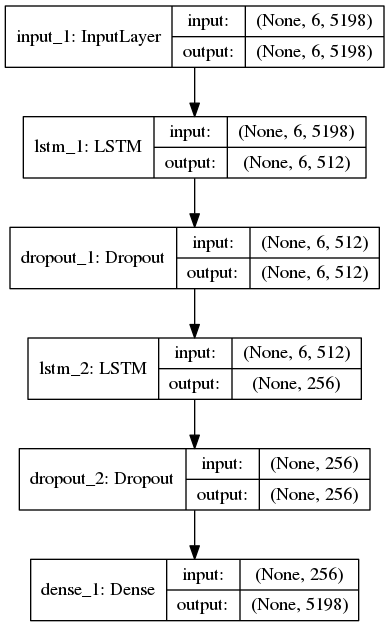

In [18]:
# 在目录下将产生一个名为“model.png”的图片，显示出这个多层的神经网络模型图
from keras.utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True)

## 5.训练模型

因为训练数据实在比较耗时间。这里提供了两种方式，一种是常规的直接训练，考虑到时间太长，于是提供了一定轮次后保存一次模型，省得停不下来。另一种是复合训练，训练几轮后，测试模型，输出真实的预测结果，让用户可以根据模型的输出表现来决定什么时候停止训练。

### 5.1 常规训练

到底要训练多少次比较好？原案例的作者也没有给出答案，就提供了一个计算公式，3万多轮。

In [19]:
# 确定训练的次数
number_of_epoch = len(files_content)-(c.max_len + 1) * poems_num
number_of_epoch /= c.batch_size 
number_of_epoch = int(number_of_epoch / 1.5)
print(number_of_epoch)

31896


要训练的轮次很大，中间没办法停止。建议每隔一定的轮次停止一下，保存一下模型。

In [20]:
## 开始训练，不带反馈
model.fit_generator(
    generator=data_generator(files_content,words,word2numF,c.max_len),
    verbose=True,
    steps_per_epoch=c.batch_size,
    epochs=4)

Epoch 1/1
32/32 [==============================] - 82s 3s/step - loss: 8.5494 - acc: 0.0000e+00


写一个循环，训练32次，会保存一下模型。

In [ ]:
# 每隔32轮保存一下，并输出
for e in range(number_of_epoch//32):
    model.fit_generator(
        generator=data_generator(files_content,words,word2numF,c.max_len),
        verbose=True,
        steps_per_epoch=c.batch_size,
        epochs=32)
    model.save(c.weight_file)
    flog="模型保存次数：" + str(e+1)
    print(flog)
    # 训练时的预测结果写入txt
    with open(c.fixlog, 'a',encoding='utf-8') as f:
        f.write(flog+'\n')

### 5.2 复合训练

其实就是边训练边测试。训练几轮（我使用5次），随机找某一首诗的第一行，测试当前的模型，输出真实的预测结果，让用户可以根据模型的输出表现来决定什么时候停止。

首先需要写一个LambdaCallback函数：generate_sample_result。

In [21]:
# 回调函数(输出训练结果到反馈)
def generate_sample_result(epoch, logs):
    '''训练过程中，每5个epoch打印出当前的学习情况'''
    if epoch % c.predict_num != 0:
        return

    with open(c.fixlog, 'a',encoding='utf-8') as f:
        f.write('==================Epoch {}=====================\n'.format(epoch))

    print("\n==================Epoch {}=====================".format(epoch))
    for diversity in [0.7, 1.0, 1.3]:
        print("------------Diversity {}--------------".format(diversity))
        # 使用不同的temperature值，输出三种诗
        generate = predict_random(temperature=diversity)
        print(generate)

        # 训练时的预测结果写入txt
        with open(c.fixlog, 'a',encoding='utf-8') as f:
            f.write(generate+'\n')

In [22]:
# 测试函数：随机从选取诗句，生成五言绝句
def predict_random(temperature = 1):
    '''随机从库中选取一句开头的诗句，生成五言绝句'''
    if not model:
        print('model not loaded')
        return
    # 随机找一首诗，用第一行来测试
    index = random.randint(0, poems_num)
    sentence = poems[index][: c.max_len]
    generate = predict_sen(sentence,temperature=temperature)
    return generate

In [23]:
# 根据给出的前max_len个字，生成诗句
def predict_sen(text,temperature =1):
    '''此例中，即根据给出的第一句诗句（含逗号），来生成古诗'''
    max_len = c.max_len
    if len(text)<max_len:
        print('字数不能少于',max_len)
        return

    sentence = text[-max_len:]
    # print('第一句:',sentence)
    generate = str(sentence)
    generate += m_preds(sentence,length = 24-max_len,temperature=temperature)
    return generate

In [24]:
# 输入字符串，返回字符串
def m_preds(sentence,length = 23,temperature =1):
    '''
    sentence:预测输入值
    lenth:预测出的字符串长度
    供类内部调用，输入max_len长度字符串，返回length长度的预测值字符串
    '''
    sentence = sentence[:c.max_len]
    generate = ''
    for i in range(length):
        pred = m_pred(sentence,temperature)
        generate += pred
        sentence = sentence[1:]+pred
    return generate

In [25]:
# 输入字符串，返回字符
def m_pred(sentence,temperature =1):
    '''内部使用方法，根据一串输入，返回单个预测字符'''
    if len(sentence) < c.max_len:
        print('in def m_pred,length error ')
        return

    sentence = sentence[-c.max_len:]
    x_pred = np.zeros((1, c.max_len, len(words)))
    for t, char in enumerate(sentence):
        x_pred[0, t, word2numF(char)] = 1.
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds,temperature=temperature)
    next_char = num2word[next_index]

    return next_char

In [26]:
# 根据输入的矩阵，返回一个数字
def sample(preds, temperature=1.0):
    '''
    当temperature=1.0时，模型输出正常
    当temperature=0.5时，模型输出比较open
    当temperature=1.5时，模型输出比较保守
    在训练的过程中可以看到temperature不同，结果也不同
    就是一个概率分布变换的问题，保守的时候概率大的值变得更大，选择的可能性也更大
    '''
    preds = np.asarray(preds).astype('float64')
    exp_preds = np.power(preds,1./temperature)
    preds = exp_preds / np.sum(exp_preds)
    pro = np.random.choice(range(len(preds)),1,p=preds)
    return int(pro.squeeze())

In [ ]:
# 确定训练的次数
number_of_epoch = len(files_content)-(c.max_len + 1) * poems_num
number_of_epoch /= c.batch_size 
number_of_epoch = int(number_of_epoch / 1.5)
## 开始训练，带反馈
model.fit_generator(
    generator=data_generator(files_content,words,word2numF,c.max_len),
    verbose=True,
    steps_per_epoch=c.batch_size,
    epochs=number_of_epoch,
    callbacks=[
        keras.callbacks.ModelCheckpoint(c.weight_file, save_weights_only=False),
        LambdaCallback(on_epoch_end=generate_sample_result)])

开始训练后，每隔一定的轮次（predict_num），这些信息都会输出到训练的日志文件（fixlog）中。

## 6.应用模型

这个模型的作用是：根据输入的一组字（6个字符）来预测第7个字。那么利用这一点就可以做出很多应用，如藏头诗、藏字诗、随机作诗等。

In [34]:
model = load_model(c.weight_file,compile=False)

### 6.1 藏头诗

输入必须是四个字，并且不能有冷僻字。为了使诗句有点意义，先在诗词库中找一句某个字开头的诗，如果找不到，再随机凑一句。

In [36]:
# '''根据给4个字，生成藏头诗五言绝句'''
def predict_hide(text,temperature = 1):
    if len(text)!=4:
        print('藏头诗的输入必须是4个字！')
        return
    islow=''
    for t in text:
        if t not in words:
            islow = t
            break
    if islow:
        print('输入的字存在冷僻字：'+ islow)
        return

    index = random.randint(0, poems_num)
    #选取随机一首诗的最后max_len字符+给出的首个文字作为初始输入
    sentence = poems[index][1-c.max_len:] + text[0]
    generate = str(text[0])
    #print('引子 = ',sentence)

    for i in range(5):
        next_char = m_pred(sentence,temperature)           
        sentence = sentence[1:] + next_char
        generate+= next_char

    for i in range(3):
        generate += text[i+1]
        sentence = sentence[1:] + text[i+1]
        for i in range(5):
            next_char = m_pred(sentence,temperature)           
            sentence = sentence[1:] + next_char
            generate+= next_char

    return generate
# 执行
for i in range(3):
    #藏头诗
    sen = predict_hide('春夏秋冬')
    print(sen)

春疑更钓虚，夏华管初正。秋夕不物言，冬歌玉起日。
春林春风烟，夏朝雪木轻。秋传沈多鹿，冬里交时入。
春三书年华，夏百关龙惜。秋谁多还风，冬丹学地转。


In [38]:
# predict_sen函数在前面已经运行
for i in range(3):
    #给出第一句话进行预测
    sen = predict_sen('明月松间照，')
    print(sen)

明月松间照，声扬中当正。传青离明心，事朝长时泥。
明月松间照，将雪有功朝。上沈自阳日，复白水紫来。
明月松间照，金重才绿接。场双北时女，山草重故先。


In [39]:
#'''根据给出的首个文字，生成五言绝句'''
def predict_first(char,temperature =1):
    index = random.randint(0, poems_num)
    #选取随机一首诗的最后max_len字符+给出的首个文字作为初始输入
    sentence = poems[index][1-c.max_len:] + char
    generate = str(char)
    # print('引子 = ',sentence)
    # 直接预测后面23个字符
    generate += m_preds(sentence,length=23,temperature=temperature)
    return generate

# 执行
for i in range(3):
    #给出第一个字进行预测
    sen = predict_first('山')
    print(sen)

山流留江承，图君泥春在。行白游紫远，新犹历不林。
山思水行雪，动三开河闲。药流起日取，此树空白野。
山海幽花楼，夜去言何石。连应东地绕，郡月一玉为。


In [40]:
#'''随机从库中选取一句开头的诗句，生成五言绝句'''
def predict_random(temperature = 1):
    index = random.randint(0, poems_num)
    sentence = poems[index][: c.max_len]
    generate = predict_sen(sentence,temperature=temperature)
    return generate

# 执行
for temp in [0.5,1,1.5]:
    #随机抽取第一句话进行预测
    sen = predict_random(temperature=temp)
    print(sen)

神女向高唐，北玉复梁言。心南年向从，风白歌黄向。
古墓芙蓉塔，西客庭去路。玉惜疑应空，命鸣作鹤书。
仆本儒家子，庭作说要空。别一人径生，华门丘辛叹。


具体效果如何？大家的要求不能太高啊。虽然这个模型有点大，但是虚谷号还是可以正常运行。